# Exploring "ERA5" using tensorlakehouse

### Data description
* Collection/dataset:"ERA5"
* Data Source: Geotiff on Cloud Object Store (COS) 

### Functionalities
* tensorlakehouse (openEO) functionalities:
    - describe collection
    - load collection

### Setup

1. Create a python virtualenv (python 3.11.7 is the recommended version). 
2. Clone the repository:
```
git clone https://github.com/IBM/tensorlakehouse-openeo-driver.git
``` 

3. Go to
```
cd tensorlakehouse-openeo-driver/tutorials
```

4. Install dependencies:
```
pip install -r tutorial_requirements.txt
```

5. Run jupyter notebook or jupyter lab
```
jupyter lab .
```


In [1]:
import rioxarray as rxr
import os
os.environ['USE_PYGEOS'] = '0'
import matplotlib.pyplot as plt
from pathlib import Path
# openeo is a client-side implementation that allows users to query OpenEO service
import openeo
# pystac_client is a client-side implementation that allows users to query STAC service
from pystac_client import Client
# OpenEO service URL
import os
from dotenv import load_dotenv
import pandas as pd
import xarray as xr
from shapely.geometry import shape
import geopandas
import folium
import time

Set URL and credentials of the OpenEO service

In [2]:
# username and password are hardcoded in the backend as an example for testing
load_dotenv()
STAC_URL="https://stac-fastapi-pgstac-geospatial-be.apps.fmaas-backend.fmaas.res.ibm.com"
OPENEO_URL="https://tensorlakehouse-openeo-driver-geospatial-be.apps.fmaas-backend.fmaas.res.ibm.com"
OPENEO_AUTH_CLIENT_ID = os.environ["OPENEO_AUTH_CLIENT_ID"]
OPENEO_AUTH_CLIENT_SECRET = os.environ["OPENEO_AUTH_CLIENT_SECRET"]
APPID_USERNAME = os.environ["APPID_USERNAME"]
APPID_PASSWORD = os.environ["APPID_PASSWORD"]

# connect to tensorlakehouse
tensorlakehouse_conn = openeo.connect(OPENEO_URL).authenticate_oidc_resource_owner_password_credentials(
username=APPID_USERNAME,
password=APPID_PASSWORD,
client_id=OPENEO_AUTH_CLIENT_ID,
client_secret=OPENEO_AUTH_CLIENT_SECRET,
provider_id="app_id")

catalog = Client.open(STAC_URL)

### Setting input parameters: time range, area of interest, collection ID, filter

In [3]:
# set time interval
start ='2024-01-01T00:00:00Z'
end = '2024-01-01T12:00:00Z'
time_range = f"{start}/{end}"

# set bounding box
west = -1.0
east = 0.0
south = 51.0
north = 52.0

collection_id = "ibm-eis-ga-1-era5-pr-wdc"

# create data dir to save files
data_dir = Path("test_data")
if not data_dir.exists():
    data_dir.mkdir()

### Searching STAC items 

In [4]:
bbox=[west, south, east, north]
print(f"Searching {collection_id=} {bbox=} datetime={time_range}")
result = catalog.search(collections=[collection_id], bbox=bbox, datetime=time_range)
counter = 0
ids = list()
geometry = list()
timestamp = list()
bands = list()

for item in result.items_as_dicts():
    ids.append(item["id"])
    geometry.append(shape(item["geometry"]))
    timestamp.append(pd.Timestamp(item["properties"]["datetime"]))
    bands.append(list(item["properties"]["cube:variables"].keys()))
    
gdf = geopandas.GeoDataFrame(data={"id": ids, "datetime": timestamp, "bands": bands}, geometry=geometry)
gdf



Searching collection_id='ibm-eis-ga-1-era5-pr-wdc' bbox=[-1.0, 51.0, 0.0, 52.0] datetime=2024-01-01T00:00:00Z/2024-01-01T12:00:00Z


,id,datetime,bands,geometry
0,ERA5P_20240101T120000__ttrc_120000_0_0,2024-01-01 12:00:00+00:00,[ttrc],"POLYGON ((-180.00000 -90.00000, -180.00000 90...."
1,ERA5P_20240101T120000__ttr_120000_0_0,2024-01-01 12:00:00+00:00,[ttr],"POLYGON ((-180.00000 -90.00000, -180.00000 90...."
2,ERA5P_20240101T120000__tsrc_120000_0_0,2024-01-01 12:00:00+00:00,[tsrc],"POLYGON ((-180.00000 -90.00000, -180.00000 90...."
3,ERA5P_20240101T120000__tsr_120000_0_0,2024-01-01 12:00:00+00:00,[tsr],"POLYGON ((-180.00000 -90.00000, -180.00000 90...."
4,ERA5P_20240101T120000__tp_120000_0_0,2024-01-01 12:00:00+00:00,[tp],"POLYGON ((-180.00000 -90.00000, -180.00000 90...."
...,...,...,...,...
619,ERA5P_20240101T000000__10v_000000_0_0,2024-01-01 00:00:00+00:00,[10v],"POLYGON ((-180.00000 -90.00000, -180.00000 90...."
620,ERA5P_20240101T000000__10u_000000_0_0,2024-01-01 00:00:00+00:00,[10u],"POLYGON ((-180.00000 -90.00000, -180.00000 90...."
621,ERA5P_20240101T000000__10fg_000000_0_0,2024-01-01 00:00:00+00:00,[10fg],"POLYGON ((-180.00000 -90.00000, -180.00000 90...."
622,ERA5P_20240101T000000__100v_000000_0_0,2024-01-01 00:00:00+00:00,[100v],"POLYGON ((-180.00000 -90.00000, -180.00000 90...."


In [5]:
available_timestamps = sorted(gdf["datetime"].unique())
print(f"Available timestamps = {available_timestamps}")
available_bands = set([b.pop() for b in gdf["bands"]])
print(f"Available bands: {available_bands}")

Available timestamps = [Timestamp('2024-01-01 00:00:00+0000', tz='UTC'), Timestamp('2024-01-01 01:00:00+0000', tz='UTC'), Timestamp('2024-01-01 02:00:00+0000', tz='UTC'), Timestamp('2024-01-01 03:00:00+0000', tz='UTC'), Timestamp('2024-01-01 04:00:00+0000', tz='UTC'), Timestamp('2024-01-01 05:00:00+0000', tz='UTC'), Timestamp('2024-01-01 06:00:00+0000', tz='UTC'), Timestamp('2024-01-01 07:00:00+0000', tz='UTC'), Timestamp('2024-01-01 08:00:00+0000', tz='UTC'), Timestamp('2024-01-01 09:00:00+0000', tz='UTC'), Timestamp('2024-01-01 10:00:00+0000', tz='UTC'), Timestamp('2024-01-01 11:00:00+0000', tz='UTC'), Timestamp('2024-01-01 12:00:00+0000', tz='UTC')]
Available bands: {'tcsw', 'swvl3', '100v', 'swvl2', 'swvl1', 'i10fg', 'fdir', '10v', '10u', 'sd', 'tcw', '100u', '10fg', 'tsr', 'stl3', '2t', '2d', 'mn2t', 'mxtpr', 'lcc', 'strdc', 'stl2', 'tcrw', 'mntpr', 'ttrc', 'rsn', 'stl1', 'swh', 'tp', 'mwp', 'tsrc', 'msl', 'ssrd', 'ssrdc', 'stl4', 'sst', 'tcwv', 'sp', 'mx2t', 'mwd', 'mcc', 'strd',

### Describing the collection using Tensorlakehouse

In [6]:
tensorlakehouse_conn.describe_collection(collection_id)

{'cube:dimensions': {'bands': {'type': 'bands',
   'values': ['100u',
    '100v',
    '10fg',
    '10u',
    '10v',
    '2d',
    '2t',
    'fdir',
    'hcc',
    'i10fg',
    'lcc',
    'mcc',
    'mn2t',
    'mx2t',
    'mntpr',
    'mxtpr',
    'msl',
    'ptype',
    'rsn',
    'sd',
    'sf',
    'sp',
    'ssrd',
    'ssrdc',
    'sst',
    'stl1',
    'stl2',
    'stl3',
    'stl4',
    'strd',
    'strdc',
    'swh',
    'swvl1',
    'swvl2',
    'swvl3',
    'swvl4',
    'tcc',
    'tcrw',
    'tcsw',
    'tcw',
    'tcwv',
    'tp',
    'tsr',
    'tsrc',
    'ttr',
    'ttrc',
    'Wave-height-l10',
    'Wave-direction',
    'Wave-period',
    'cl',
    'dl',
    'cvl',
    'cvh',
    'tvl',
    'tvh',
    'slt',
    'sdfor',
    'z',
    'sdor',
    'isor',
    'anor',
    'slor',
    'lsm']},
  'time': {'extent': ['1993-01-01T00:00:00+00:00', None], 'type': 'temporal'},
  'x': {'axis': 'x', 'extent': [-180.0, 180.0], 'type': 'spatial'},
  'y': {'axis': 'y', 'extent': [-90.0, 90.0], 'type': 'spatial'}},
 'deprecated': False,
 'description': 'A global reanalysis data set produced by ECMWF, the European Centre for Medium-Range Weather Forecasts. ERA5 is the direct successor to the ERA Interim reanalysis. It provides global, hourly data at a resolution of 0.25 by 0.25 degrees. | As any reanalysis product, ERA5 combines observed data with the output of meteorological models. Note that there are actually two versions of ERA5 data. Initial data is referred to as ERA5T and available in near real time. I.e., ERA5T data lags real time by about three days. About three months later, the final version of the data is released. This is the actual ERA5 data. This dataset contains both ERA5 and ERA5T data. With the latter being uploaded initially and overwritten once the former is available. As far as currently known, differences between the two versions are negligible. The dataset contains data for 1980, 1990, 2000, 2005 and from 2009 onwards. | {https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels,https://confluence.ecmwf.int/display/CKB/ERA5%3A+What+is+the+spatial+reference,https://en.wikipedia.org/wiki/Meteorological_reanalysis,https://www.ecmwf.int/en/newsletter/159/meteorology/global-reanalysis-goodbye-era-interim-hello-era5}',
 'extent': {'spatial': {'bbox': [[-180, -90, 180, 90]]},
  'temporal': {'interval': [['1993-01-01T00:00:00Z', None]]}},
 'id': 'ibm-eis-ga-1-era5-pr-wdc',
 'keywords': [],
 'license': 'Generated using Copernicus Climate Change Service information 2024. Neither the European Commission nor ECMWF is responsible for any use that may be made of the Copernicus information or data it contains.',
 'links': [{'href': 'http://stac-fastapi-pgstac.geospatial-be.svc.cluster.local:8080/collections/ibm-eis-ga-1-era5-pr-wdc/items',
   'rel': 'items',
   'type': 'application/geo+json'},
  {'href': 'http://stac-fastapi-pgstac.geospatial-be.svc.cluster.local:8080/',
   'rel': 'parent',
   'type': 'application/json'},
  {'href': 'http://stac-fastapi-pgstac.geospatial-be.svc.cluster.local:8080/',
   'rel': 'root',
   'title': 'stac-fastapi',
   'type': 'application/json'},
  {'href': 'http://stac-fastapi-pgstac.geospatial-be.svc.cluster.local:8080/collections/ibm-eis-ga-1-era5-pr-wdc',
   'rel': 'self',
   'type': 'application/json'}],
 'providers': [{'description': 'Producers of awesome spatiotemporal assets',
   'name': 'IBM',
   'roles': ['producer', 'processor'],
   'url': 'https://www.ibm.com'}],
 'stac_extensions': ['https://stac-extensions.github.io/datacube/v2.2.0/schema.json'],
 'stac_version': '1.0.0',
 'summaries': {},
 'title': 'Global weather (ERA5) IBM COS',
 'type': 'Collection',
 'version': ''}

## Loading tensorlakehouse datacube

In [7]:
bands = ["2t"]
spatial_extent={
        'west' : west,
        'south' : south,
        'east' : east,
        'north' : north
    }

temporal_extent = [start, end]

print(f"{collection_id=} {spatial_extent=} {temporal_extent=} {bands=}")

cube = tensorlakehouse_conn.load_collection(
    collection_id=collection_id,
    spatial_extent=spatial_extent,
    temporal_extent=temporal_extent,
    bands=bands,
)


collection_id='ibm-eis-ga-1-era5-pr-wdc' spatial_extent={'west': -1.0, 'south': 51.0, 'east': 0.0, 'north': 52.0} temporal_extent=['2024-01-01T00:00:00Z', '2024-01-01T12:00:00Z'] bands=['2t']


In [8]:
output_format = "netCDF"
cube = cube.save_result(output_format)

### Submit a batch job and wait until it finishes

In [9]:
# create a batch jobs
job = cube.create_job(out_format=output_format)
job_status = job.status()
job_id = job.job_id
# create a directory to store the results
output_dir = data_dir / f"test_batch_jobs_{job_id}"
if not output_dir.exists():
    output_dir.mkdir()
# while jobs is still in progress, wait for it
while job_status not in ["canceled", "finished", "error"]:
    time.sleep(3)
    job_status = job.status()
    print(f"{job_status=}")
# get results
results = job.get_results()
# download files
results.download_files(output_dir)
print(f"Downloaded to {output_dir} directory")

Preflight process graph validation raised: [Internal] 'TensorLakehouseProcessRegistry' object has no attribute 'get_function'


job_status='finished'
Downloaded to test_data/test_batch_jobs_5f07c14c-85fe-4fb0-8e13-00c0be8abec2 directory


### List files, open the netcdf file and plot the image

In [10]:
downloaded_files = list(output_dir.glob("*"))
downloaded_files

[PosixPath('test_data/test_batch_jobs_5f07c14c-85fe-4fb0-8e13-00c0be8abec2/20240729T223352-5f07c14c-85fe-4fb0-8e13-00c0be8abec2.nc'),
 PosixPath('test_data/test_batch_jobs_5f07c14c-85fe-4fb0-8e13-00c0be8abec2/job-results.json')]

In [11]:
# listing all netcdf files
netcdf_files = [f for f in downloaded_files if f.suffix == ".nc"]
ds = xr.open_dataset(netcdf_files[0])
ds

<xarray.Dataset> Size: 7kB
Dimensions:      (time: 13, y: 8, x: 8)
Coordinates:
  * time         (time) datetime64[ns] 104B 2024-01-01 ... 2024-01-01T12:00:00
  * x            (x) float64 64B -1.049 -0.9175 -0.7864 ... -0.2621 -0.1311
  * y            (y) float64 64B 52.04 51.9 51.77 51.64 51.51 51.38 51.25 51.12
Data variables:
    2t           (time, y, x) float64 7kB ...
    spatial_ref  int64 8B ...
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-1.048576, 50.987007999999996,...
    transform:   [ 0.131072  0.       -1.048576  0.       -0.131072 52.035584...
    resolution:  0.131072

In [12]:
ds.time.values

array(['2024-01-01T00:00:00.000000000', '2024-01-01T01:00:00.000000000',
       '2024-01-01T02:00:00.000000000', '2024-01-01T03:00:00.000000000',
       '2024-01-01T04:00:00.000000000', '2024-01-01T05:00:00.000000000',
       '2024-01-01T06:00:00.000000000', '2024-01-01T07:00:00.000000000',
       '2024-01-01T08:00:00.000000000', '2024-01-01T09:00:00.000000000',
       '2024-01-01T10:00:00.000000000', '2024-01-01T11:00:00.000000000',
       '2024-01-01T12:00:00.000000000'], dtype='datetime64[ns]')

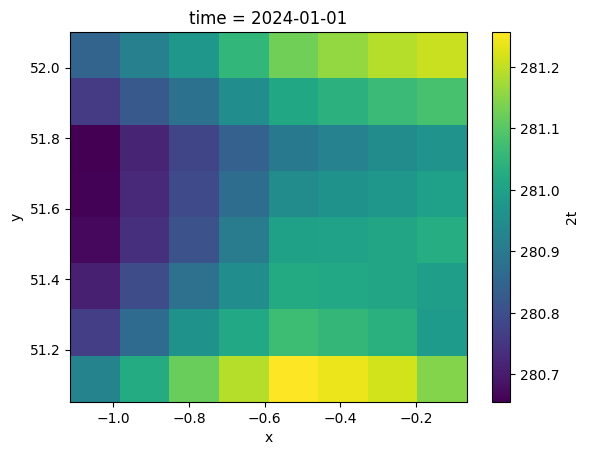

In [13]:
# open all raster files and concatenate

da = ds[bands[0]]
da.isel({"time":0}).plot()